In [1]:
%load_ext autoreload
%autoreload 2

# Simple example CBPS using Lalonde

In [3]:
import sys
sys.path.append('..')
from src.cbps_torch import CBPS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [4]:
# Read lalonde data
df = pd.read_csv("../data/lalonde_psid.csv")
df.head()

,age,education,black,hispanic,married,nodegree,re74,re75,re78,u74,u75,treat
0,37,11,1,0,1,1,0.0,0.0,9930.05,1,1,1
1,22,9,0,1,0,1,0.0,0.0,3595.89,1,1,1
2,30,12,1,0,0,0,0.0,0.0,24909.50,1,1,1
3,27,11,1,0,0,1,0.0,0.0,7506.15,1,1,1
4,33,8,1,0,0,1,0.0,0.0,289.79,1,1,1


In [5]:
w, y = df.treat.values, df.re78.values
X = df.drop(columns=["treat", "re78"]).values
X = MinMaxScaler().fit_transform(X)

In [6]:
print(f" Our effect benchmark is given by: {y[w == 1].mean() - y[w == 0].mean()}")

 Our effect benchmark is given by: -15204.775555988717


## Experiments with dimensionality reduction and playing with other parameters

In [57]:
list_tau = []
for _ in range(100):
        cbps = CBPS(X = X,
                W = w,
                estimand="ATT",
                intercept=True,
                noi=False,
                niter=10000,
                lr=1e-2,
                reg=None,
                svd=5
        )
        weights = cbps.weights()
        tau = y[w == 1].mean() - np.average(y[w == 0], weights=weights.data.cpu().numpy())
        list_tau.append(tau)

Optimizing CBPS...: 100%|██████████| 10000/10000 [00:02<00:00, 3372.55it/s]


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1., 97.]),
 array([1061.69138621, 1125.97899953, 1190.26661286, 1254.55422619,
        1318.84183951, 1383.12945284, 1447.41706617, 1511.70467949,
        1575.99229282, 1640.27990614, 1704.56751947]),
 <BarContainer object of 10 artists>)

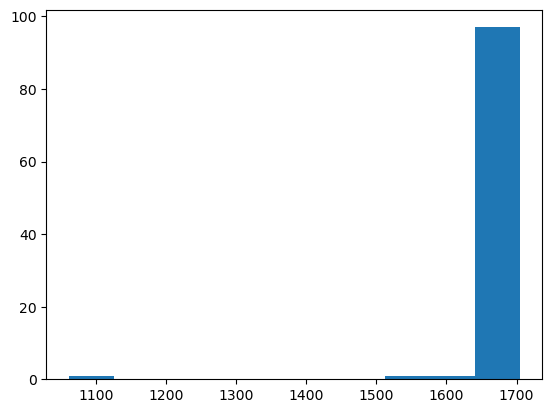

In [60]:
plt.hist(np.array(list_tau))

In [61]:
list_tau = []
for _ in range(100):
        cbps = CBPS(X = X,
                W = w,
                estimand="ATT",
                intercept=True,
                noi=False,
                niter=10000,
                lr=1e-2
        )
        weights = cbps.weights()
        tau = y[w == 1].mean() - np.average(y[w == 0], weights=weights.data.cpu().numpy())
        list_tau.append(tau)

Optimizing CBPS...: 100%|██████████| 10000/10000 [00:03<00:00, 3125.92it/s]


(array([ 1.,  0.,  0.,  2.,  0.,  0.,  5.,  3.,  8., 81.]),
 array([1430.19719308, 1532.04672647, 1633.89625986, 1735.74579324,
        1837.59532663, 1939.44486002, 2041.2943934 , 2143.14392679,
        2244.99346018, 2346.84299356, 2448.69252695]),
 <BarContainer object of 10 artists>)

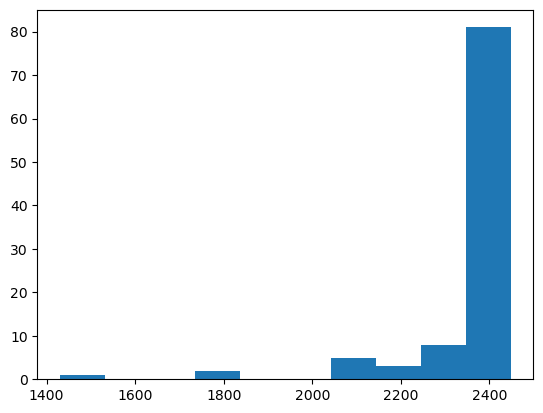

In [62]:
plt.hist(np.array(list_tau))